## Import data:

In [585]:
import scipy.io as s
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from collections import defaultdict
from sklearn import preprocessing as preprocess
import math
from numpy.linalg import norm as nm
import time
import itertools

from deap import algorithms as algorithm_ea
from deap import base as ba
from deap import creator as create_EA
from deap import tools as EA_tools

import random
import operator

# learned from stackoverflow
# read in matlab files learned from stackoverflow

# https://stackoverflow.com/questions/874461/read-mat-files-in-python 
# https://stackoverflow.com/questions/38197449/matlab-data-file-to-pandas-dataframe
print('import data')
data_signal = s.loadmat('uci_eeg_features.mat')
print('\n')
print('\n')
# extract keys learned from
# https://www.geeksforgeeks.org/python-ways-to-remove-a-key-from-dictionary/

data_signal.pop('__header__')
data_signal.pop('__version__')
data_signal.pop('__globals__')
data_signal['data']

data_signal['y_alcoholic'] = (data_signal['y_alcoholic'])[0]
data_signal['y_stimulus'] = (data_signal['y_stimulus'])[0]
data_signal['subjectid'] = (data_signal['subjectid'])[0]
data_signal['trialnum'] = (data_signal['trialnum'])[0]

# create the pandas dataframe inspired by https://www.cnblogs.com/nxf-rabbit75/p/11088925.html
signal_dataset = pd.DataFrame.from_dict(data_signal, orient = 'index')
signal_dataset

# next block is data preprocessing
# .....................................

import data






C:\Users\song\Anaconda3\lib\site-packages\pandas\core\internals\construction.py:309: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0
data,"[[0.6281534622439293, 0.13222229361815308, 0.5..."
y_alcoholic,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
y_stimulus,"[1, 1, 2, 3, 1, 4, 1, 1, 2, 3, 1, 2, 1, 1, 3, ..."
subjectid,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
trialnum,"[0, 2, 7, 9, 10, 11, 12, 14, 15, 17, 18, 19, 2..."


## data preprocessing:

data_x:  [[0.62815346 0.13222229 0.50421539 ... 0.65466432 0.27507389 0.51046363]
 [4.20861645 1.79166401 0.41412987 ... 0.75365655 0.42452412 0.48401491]
 [2.6085142  0.78606359 0.36854814 ... 0.48118327 0.40367651 0.45220646]
 ...
 [0.52471996 0.3162305  0.18141482 ... 0.76906148 0.34947668 0.18573812]
 [0.70324803 0.17817543 0.28161415 ... 0.85660129 0.40638949 0.27114099]
 [1.55529484 0.5605464  0.23795404 ... 1.16539107 0.61241659 0.31115942]]
data_y:  [1 1 1 ... 0 0 0]
grouping data to create within subject test and cross subject test: 
preprocessing data: 


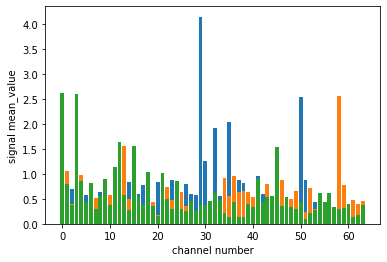

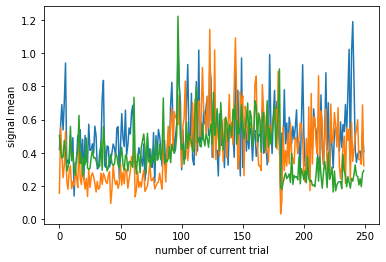

In [586]:
#data processing

datax = data_signal['data'].copy()
datax_origin = data_signal['data'].copy()

datay = data_signal['y_alcoholic']
data_subject = data_signal['subjectid']
print('data_x: ', datax)
print('data_y: ', datay)

# standardscaler

# datax = preprocess.StandardScaler().fit_transform(datax)
# datax_origin = preprocess.StandardScaler().fit_transform(datax_origin)

# cross subject
print('grouping data to create within subject test and cross subject test: ')

# https://github.com/ShiyaLiu/EEG-feature-filter-and-disguising/blob/master/DataPreprocessing/data_split_cross.py
# how to split cross subject
data_subject = data_signal['subjectid']

subject_number = list(range(1, data_subject[len(data_subject)-1]+1))
subject_number = np.array(subject_number)

split = np.random.rand(len(subject_number)) < 0.7

train_x_cross_subject = np.array([])
train_y_cross_subject = np.array([])

test_x_cross_subject = np.array([])
test_y_cross_subject = np.array([])
for x in range(0, len(data_subject)):
    if (split[data_subject[x]-1]==True):
        if len(train_x_cross_subject) == 0:
            train_x_cross_subject = np.array([datax[x]])
            train_y_cross_subject = np.array([datay[x]])
        else:
#             print('before','\n', train_datasetx, np.array([datax[x]]))
#             print('after','\n', train_datasetx, np.array([datax[x]]))
            train_x_cross_subject = np.append(train_x_cross_subject, np.array([datax[x]]), axis = 0)
            train_y_cross_subject = np.append(train_y_cross_subject, np.array([datay[x]]), axis = 0)
    elif(split[data_subject[x]-1]==False):
        if len(test_x_cross_subject) == 0:
            test_x_cross_subject = np.array([datax[x]])
            test_y_cross_subject = np.array([datay[x]])
        else:
            test_x_cross_subject = np.append(test_x_cross_subject, np.array([datax[x]]), axis = 0)
            test_y_cross_subject = np.append(test_y_cross_subject, np.array([datay[x]]), axis = 0)
            
validation_split = len(test_x_cross_subject)
sp = np.random.rand(validation_split) < 0.66
validation_x_cross_subject = test_x_cross_subject[~sp].copy()
validation_y_cross_subject = test_y_cross_subject[~sp].copy()
test_x_cross_subject = test_x_cross_subject[sp].copy()
test_y_cross_subject = test_y_cross_subject[sp].copy()

print('preprocessing data: ')

# tryed normalizing the dataset but it does not help maybe lose some of the information
# print(datax)

# preproccessor = preprocessing.MinMaxScaler()
datax = np.around(datax, decimals = 2) # https://numpy.org/doc/stable/reference/generated/numpy.around.html
# print(datax)
# divide into alpha beta theta frequency band

def extract_frequency(original_data):
    data_extract = (original_data.copy()).T
    theta_data = data_extract[0:64]
    alpha_data = data_extract[64:128]
    beta_data = data_extract[128:192]
    return alpha_data.T, beta_data.T, theta_data.T

alpha_data, beta_data, theta_data = extract_frequency(datax)
# print(len(alpha_data))

#plot of single data trial
# with dpi 1200

# plt.figure(figsize=(8, 6), dpi=1200)
plt.bar(list(range(0,64)), alpha_data[2])

# plt.legend('alpha')
plt.bar(list(range(0,64)), beta_data[2])
# plt.legend('beta')
plt.bar(list(range(0,64)), theta_data[2])
# plt.legend('theta')
plt.xlabel('channel number')
plt.ylabel('signal mean_value')
plt.show()

alpha_data, beta_data, theta_data = extract_frequency(datax_origin)
# print(len(alpha_data))

#plot of single data trial
# with dpi 1200

# plt.figure(figsize=(8, 6), dpi=1200)
plt.plot(list(range(0,250)), (alpha_data.T)[2][0:250])

plt.plot(list(range(0,250)), (beta_data.T)[2][0:250])
plt.plot(list(range(0,250)), (theta_data.T)[2][0:250])
plt.xlabel('number of current trial')
plt.ylabel('signal mean')
plt.show()



## baseline NN

In [587]:
# neural network


# hyperparameter setting inspired by lab2 https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139366
# Hyper Parameters
number_epoch = 200
batch_size = 250
input_size = 192
hidden_size = 15
number_class = 2
learning_rate = 0.0075

class alcoholismDataset(torch.utils.data.Dataset):
    # define dataset from lab and https://zhuanlan.zhihu.com/p/35698470, https://blog.csdn.net/weixin_41560402/article/details/108121344
    def __init__(self, input_x, target_y):
        self.datax_tensor = torch.Tensor(input_x)
        self.datay_tensor = torch.Tensor(target_y)

    def __getitem__(self, index):
        input_element = self.datax_tensor[index]
        target = self.datay_tensor[index]
        return input_element, target

    def __len__(self):
        n, _ = self.datax_tensor.shape
        return n

def create_training_data_and_testing_data(datax, datay):
    # this function inspired by lab2 https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139366
    # train set take up 70%, validation takes up 10$ and test set take up 20%
    total_number = len(datax)
    split = np.random.rand(total_number) < 0.7
    train_datax = datax[split].copy()
    train_datay = datay[split].copy()
    test_datax = datax[~split].copy()
    test_datay = datay[~split].copy()
    train_dataset = alcoholismDataset(train_datax, train_datay)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # use train_loader learned from lab2
    
    validation_split = len(test_datax)
    sp = np.random.rand(validation_split) < 0.66
    test_input = test_datax[sp].copy()
    test_target = test_datay[sp].copy()
    validation_datax = test_datax[~sp].copy()
    validation_datay = test_datay[~sp].copy()
#     test_input = test_datax
#     test_target = test_datay
    return train_loader, train_datax, train_datay, validation_datax, validation_datay, test_input, test_target

class Baseline_Simple_Neural_Network(nn.Module):
    # this function inspired by lab2 https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139366
    def __init__(self, input_size, hidden_size, number_class):
        super(Baseline_Simple_Neural_Network, self).__init__()
        self.linearlayer1 = nn.Linear(input_size, hidden_size)
        activation_function = nn.Sigmoid()
        self.hidden = activation_function
        self.linearlayer2 = nn.Linear(hidden_size, number_class)

    def forward(self, x):
        layer_output = self.linearlayer1(x)
        layer_output = self.hidden(layer_output)
        layer_output = self.linearlayer2(layer_output)
        return layer_output

def train_model(number_epoch, network, train_loader, optimizer, criterion):
    # this function inspired by lab2 https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139366
    # record loss
    output_loss = []
    output_weight = 0
    for epoch in range(0, number_epoch):
        total = 0
        correct = 0
        total_loss = 0
        for step, (batch_x, batch_y) in enumerate(train_loader):
            bx = batch_x
            by = batch_y.long()

            optimizer.zero_grad()
            outputs = network(bx)
            loss = criterion(outputs, by)
            loss.backward()
            optimizer.step()
            
            record_status = ((epoch+1) % 25 == 0)
            show_status = ((epoch+1) % 100 == 0)
            if (record_status):
                _, predicted = torch.max(outputs, 1)
                # calculate and print accuracy
                total = total + predicted.size(0)
                correct = correct + sum(predicted.data.numpy() == by.data.numpy())
                total_loss += loss
        if (record_status):
            output_loss.append((total_loss).item())
            # record current loss into output_loss
        if (show_status):
            print('Epochs: ', epoch+1, ' of total', number_epoch, 'with loss: ',(total_loss).float(), 'and of train accuracy: ', 100 * correct/total)
            output_loss.append((total_loss).item())
    for (name, parameter) in network.named_parameters():
        if (name == 'linearlayer1.weight'):
            output_weight = parameter
    return output_loss, output_weight

def test_model(test_input, network, test_target):
    # this function inspired by lab2 https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139366 and implemented by myself
    targets = torch.Tensor(test_target).long()
    inputs = torch.Tensor(test_input).float()

    outputs = network(inputs)

    dimension = 1
    possibility, predicted = torch.max(outputs, dimension)
    total = len(predicted)
    correct_number = sum(predicted.data.numpy() == targets.data.numpy())
    test_accuracy = 100 * (correct_number/total)
    print('Testing Accuracy: ', test_accuracy)
    return test_accuracy

def train_test_neural_network(datax, datay, number_epoch, input_size, hidden_size, learning_rate, number_class):
    # train and test neural network learned in lab2
    train_loader, train_datax, train_datay, validation_datax, validation_datay, test_input, test_target = create_training_data_and_testing_data(datax, datay)
    base_net = Baseline_Simple_Neural_Network(input_size, hidden_size, number_class)
    # cross entropyloss
    criterion = nn.CrossEntropyLoss()
    # adam optimiser
    optimizer = torch.optim.Adam(base_net.parameters(), lr=learning_rate)
    # train the model by batch
    output_loss2, output_weight = train_model(number_epoch, base_net, train_loader, optimizer, criterion)
    # test model
    test_model(test_input, base_net, test_target)
    return output_weight

print('base line neural network: ')
print('\n')

# 
output_weight = train_test_neural_network(datax, datay, number_epoch, input_size, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

base line neural network: 


Epochs:  100  of total 200 with loss:  tensor(9.0050, grad_fn=<AddBackward0>) and of train accuracy:  87.81217481789803
Epochs:  200  of total 200 with loss:  tensor(6.4304, grad_fn=<AddBackward0>) and of train accuracy:  91.974505723205
Testing Accuracy:  86.97214734950583






## functional measurement

In [588]:

# functional measurement I and W
def I_measure_of_angle(input_index1, input_index2, all_inputs, number_patterns):
    # model I introduced by Gedeon
    # here cos measurement of degree is used to speed up the process, but if the denominator is 0 then use the original method
    numer = np.dot(all_inputs[input_index1], all_inputs[input_index2])
    denom = np.linalg.norm(all_inputs[input_index1]) * np.linalg.norm(all_inputs[input_index2])
    if denom == 0:
        #use original method
        numer1 = 0
        numer2 = 0
        denom = 0
        for x in range(0, number_patterns):
            numer1 += ((all_inputs[input_index1])[x] - 0.5)*((all_inputs[input_index1])[x] - 0.5)
            numer2 += ((all_inputs[input_index2])[x] - 0.5)*((all_inputs[input_index2])[x] - 0.5)
        for y in range(0, number_patterns):
            product = ((all_inputs[input_index1])[y]-0.5)*((all_inputs[input_index2])[y]-0.5)
            denom += product*product
        numer = numer1 * numer2
        angle_result = math.sqrt(numer/denom)-1
        output = math.atan(angle_result)*180/math.pi
    else:
        angle_result = numer/denom
        output = math.acos(angle_result)*180/math.pi
    return output

def W_measure_of_angle(input_index1, input_index2, output_weight, number_hidden):
    # model W introduced by Gedeon
    output_weight_numpy = output_weight.detach().numpy()
    numer = np.dot(output_weight_numpy[input_index1], output_weight_numpy[input_index2])
    denom = np.linalg.norm(output_weight_numpy[input_index1]) * np.linalg.norm(output_weight_numpy[input_index2])
    
    if denom == 0:
        numer1 = 0
        numer2 = 0
        denom = 0
        for x in range(0, number_hidden):
            numer1 += ((output_weight[input_index1])[x] - 0.5)*((output_weight[input_index1])[x] - 0.5)
            numer2 += ((output_weight[input_index2])[x] - 0.5)*((output_weight[input_index2])[x] - 0.5)
    
        for y in range(0, number_hidden):
            product = ((output_weight[input_index1])[y]-0.5)*((output_weight[input_index2])[y]-0.5)
            denom += product*product
        numer = numer1 * numer2
        angle_result = math.sqrt(numer/denom)-1
        output = math.atan(output)*180/math.pi
    else:
        angle_result = numer/denom
        output = math.acos(angle_result)*180/math.pi
    return output

def create_combinations(combinations, alpha, beta, theta):
    # combination among frequency bands
    alpha_values = list(range(0, alpha))
    beta_values = list(range(64, beta))
    theta_values = list(range(128, theta))
    combinations_alphatheta = combinations(alpha_values, 2)
    combinations_betatheta = combinations(beta_values, 2)
    output = list(combinations(theta_values, 2)) + list(combinations_alphatheta) + list(combinations_betatheta)
    return output

def agreegation_method(ranking_I):
    # aggregate model I W into model C U
    record_dictionary = dict()
    for x in range(0, len(ranking_I)):
        element1 = (ranking_I[x])[1][0]
        if(element1 in record_dictionary):
            record_dictionary[element1]+=(ranking_I[x])[0]
        else:
            record_dictionary[element1]=(ranking_I[x])[0]
        element2 = (ranking_I[x])[1][1]
        if(element2 in record_dictionary):
            record_dictionary[element2]+=(ranking_I[x])[0]
        else:
            record_dictionary[element2]=(ranking_I[x])[0]
    ranking_sort = sorted(record_dictionary.items(), key=lambda x: x[1])
    ranking_output = []
    for y in range(0, len(ranking_sort)):
        ranking_output.append((ranking_sort[y])[0])
    return ranking_output

def delete_inputs(dataset, list_todelete):
    dataset_transpose = (dataset.copy()).T
    dataset_transpose = np.delete(dataset_transpose, list_todelete, axis=0)
    output = dataset_transpose.T
    return output


## Evolutionary algorithm

In [589]:
# EA assignment2 by using Genetic Algorithm

# code inspired by reference to https://viktorsapozhok.github.io/deap-genetic-algorithm/
# and lab 7, 8 codes https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139387

# deap library
# and https://stackoverflow.com/questions/46811850/deap-python-package-create-individuals-with-different-ranges-and-mix-of-integer

datax_Transpose = datax.T
output_weight_Transpose = output_weight.T

def fitness_function_GA_Imodel(individual):
    iteration = itertools.combinations(individual, 2)
    number_total = 0
    output = []
    for (x, y) in iteration:
        if x==y:
            return [-2] # this value is to prevent there are same position selected in the individual
        else:
            number_total+=1
            measurement_angle = I_measure_of_angle(x, y,datax_Transpose,len(datax_Transpose[0]))
            output.append(abs(measurement_angle - 90))
    return [sum(output)/number_total]

def fitness_function_GA_Wmodel(individual):
    iteration = itertools.combinations(individual, 2)
    number_total = 0
    output = []
    for (x, y) in iteration:
        if x==y:
            return [-2] # this value is to prevent there are same position selected in the individual
        else:
            number_total+=1
            measurement_angle = W_measure_of_angle(x, y,output_weight_Transpose,len(output_weight_Transpose[0]))
            output.append(abs(measurement_angle - 90))
    return [sum(output)/number_total]
        
toolbox = ba.Toolbox()

# here using the max of fitness value because we want to get the highest average measurement scores
create_EA.create("FitnessMax", ba.Fitness, weights=(1.0,))
create_EA.create("Individual", list, fitness=create_EA.FitnessMax)

# how to create attributes with bounds inspired by https://stackoverflow.com/questions/46811850/deap-python-package-create-individuals-with-different-ranges-and-mix-of-integer
toolbox.register("attr_int", random.randint, 0, 191)
# here is to remove 6 inputs, change n=3, 4 to test 9 inputs and 12 inputs
toolbox.register("individual", EA_tools.initCycle, create_EA.Individual,
                 (toolbox.attr_int, toolbox.attr_int, toolbox.attr_int),n=2)
toolbox.register("population", EA_tools.initRepeat, list,
                toolbox.individual)
# using one point cross over
toolbox.register("mate", EA_tools.cxOnePoint)

# reference to deap library

toolbox.register("mutate", EA_tools.mutUniformInt, low = 0, up = 191, indpb=0.2)
    
# GA-I method uses fitness_function_GA_Imodel, fitness_function_GA_Wmodel is used by GA-W method
toolbox.register("evaluate", fitness_function_GA_Imodel)

select_size = 4
toolbox.register("select", EA_tools.selTournament, tournsize = select_size)
pop = toolbox.population(n = 50)

# set all to build genetic algorithm

C:\Users\song\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\song\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


starting up EA algorithm, take around 15 seconds to get the result

 

total spend:  11.787580728530884 s to run Genetic Algorithm
[179, 173, 83, 86, 182, 71]
Show fitness of the best individual:  79.43036583985581


Text(0.5, 0, 'Generations')

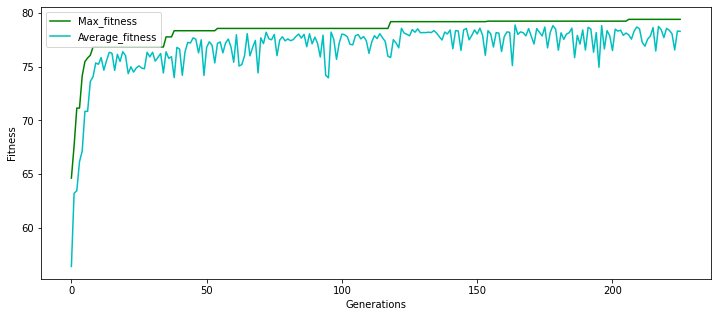

In [590]:
start = time.time()
# count time

print('starting up EA algorithm, take around 15 seconds to get the result')
print('\n', '\n')
# how to plot the log inspired by lab 7 and 8 
# https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139387

# how to set stats and get best results inspired by lab 7 and 8 
# https://wattlecourses.anu.edu.au/mod/folder/view.php?id=2139387
ve = operator.attrgetter("fitness.values")
fit_stats = EA_tools.Statistics(key=ve)
register_average = np.mean
register_max = np.max

fit_stats.register('avrg', register_average)
fit_stats.register('max', register_max)

result, log = algorithm_ea.eaSimple(pop, toolbox,cxpb=0.8, mutpb=0.2,ngen=225, verbose=False, stats=fit_stats)
# the way to get running time is learned in python time library
print('total spend: ', time.time() - start, 's to run Genetic Algorithm')
best_individual = EA_tools.selBest(result, k=1)[0]
print(best_individual)
print('Show fitness of the best individual: ', fitness_function_GA_Imodel(best_individual)[0])

plt.figure(figsize=(12, 5))
plots = plt.plot(log.select('max'),'g-', log.select('avrg'), 'c-')
plt.legend(plots, ('Max_fitness', 'Average_fitness'), frameon=True)
plt.ylabel('Fitness')
plt.xlabel('Generations')

## within subject and removing least important

In [591]:
# normal functional measurement with only combination inside each channels
#https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution

inputs_pairs = create_combinations(itertools.combinations, 64, 128, 192)

ranking_inputs_with_I_measurement=[]
ranking_inputs_with_W_measurement=[]

datax_Transpose = datax.T
output_weight_Transpose = output_weight.T

for (element1, element2) in inputs_pairs:
    angle_I_measurement = I_measure_of_angle(element1,element2,datax_Transpose,len(datax_Transpose[0]))
    
    angle_significance = abs(angle_I_measurement - 90) # if an angle between 2 inputs is less than 15 
    # or higher than 165 then it means the two inputs are similar/exclude, so they are less significant,
    # an angle between two inputs which is close to 90 means
    # the two inputs are more significant in neural network
    ranking_inputs_with_I_measurement.append((angle_significance, (element1, element2)))
print('all I angles between inputs vectors are generated')
print('______________________________________________')


for (element1, element2) in inputs_pairs:
    angle_W_measurement = W_measure_of_angle(element1, element2,output_weight_Transpose,len(output_weight_Transpose[0]))
    
    angle_significance2 = abs(angle_W_measurement - 90)
    ranking_inputs_with_W_measurement.append((angle_significance2, (element1, element2)))
print('all W angles between inputs vectors are generated')
print('__________________________________________________________________')


# .............
# sort a list by tuple inspired by https://stackoverflow.com/questions/10695139/sort-a-list-of-tuples-by-2nd-item-integer-value
ranking_inputs_with_I_measurement = sorted(ranking_inputs_with_I_measurement, key=lambda x: x[0])
print('most significant 6 pairs using model I', ranking_inputs_with_I_measurement[0:6])
print('\n')
print('\n')
print('least significant 6 pairs using model I', ranking_inputs_with_I_measurement[len(ranking_inputs_with_I_measurement)-6:len(ranking_inputs_with_W_measurement)])
ranking_inputs_with_W_measurement = sorted(ranking_inputs_with_W_measurement, key=lambda x: x[0])
print('\n')
print('\n')
print('most significant 6 pairs using model W', ranking_inputs_with_W_measurement[0:6])
print('\n')
print('\n')
print('least significant 6 pairs using model W', ranking_inputs_with_W_measurement[len(ranking_inputs_with_W_measurement)-6:len(ranking_inputs_with_W_measurement)])
# print(ranking_inputs_with_W_measurement)


rank_C = agreegation_method(ranking_inputs_with_I_measurement)

print('\n')
print('\n')

print('model_C ranking : ', rank_C) # last are least contributed inputs

rank_U = agreegation_method(ranking_inputs_with_W_measurement)
print('\n')
print('\n')

print('model_U ranking: ', rank_U) # last are least contributed inputs



iteration_C = itertools.combinations(rank_C[-6:], 2)

number_total = 0
output = []
for (x, y) in iteration_C:
    number_total+=1
    measurement_angle = I_measure_of_angle(x, y,datax_Transpose,len(datax_Transpose[0]))
    output.append(abs(measurement_angle - 90))
print('average funtional measurenment score of C:', sum(output)/number_total)




iteration_U = itertools.combinations(rank_U[-6:], 2)

number_total = 0
output = []
for (x, y) in iteration_U:
    number_total+=1
    measurement_angle = W_measure_of_angle(x, y,output_weight_Transpose,len(output_weight_Transpose[0]))
    output.append(abs(measurement_angle - 90))
print('average funtional measurenment score of U:', sum(output)/number_total)

# remove the least significant inputs by model I W C U

datax_Imeasure = datax.copy()
datax_Wmeasure = datax.copy()
datax_Cmeasure = datax.copy()
datax_Umeasure = datax.copy()



datax_Imeasure = delete_inputs(datax_Imeasure, list((ranking_inputs_with_I_measurement[len(ranking_inputs_with_I_measurement)-1])[1]))
datax_Wmeasure = delete_inputs(datax_Wmeasure, list((ranking_inputs_with_W_measurement[len(ranking_inputs_with_W_measurement)-1])[1]))
datax_Cmeasure = delete_inputs(datax_Cmeasure, rank_C[-2:])
datax_Umeasure = delete_inputs(datax_Umeasure, rank_U[-2:])

datax_I_most_sg = datax.copy()
datax_W_most_sg = datax.copy()

datax_I_most_sg = delete_inputs(datax_I_most_sg, list((ranking_inputs_with_I_measurement[0])[1]))
datax_W_most_sg = delete_inputs(datax_W_most_sg, list((ranking_inputs_with_W_measurement[0])[1]))

# testing remove 2 inputs using I C U W
print('testing I model functional measurement')
print('\n')

train_test_neural_network(datax_Imeasure, datay, number_epoch, input_size-2, hidden_size, learning_rate, number_class)
print('\n')
print('\n')

print('testing W model functional measurement')
print('\n')

train_test_neural_network(datax_Wmeasure, datay, number_epoch, input_size-2, hidden_size, learning_rate, number_class)
print('\n')
print('\n')

print('testing C model functional measurement')
print('\n')

train_test_neural_network(datax_Cmeasure, datay, number_epoch, input_size-2, hidden_size, learning_rate, number_class)
print('\n')
print('\n')

print('testing U model functional measurement')
print('\n')

train_test_neural_network(datax_Umeasure, datay, number_epoch, input_size-2, hidden_size, learning_rate, number_class)
print('\n')
print('\n')


all I angles between inputs vectors are generated
______________________________________________
all W angles between inputs vectors are generated
__________________________________________________________________
most significant 6 pairs using model I [(38.470697244894495, (93, 125)), (40.14221521704549, (93, 113)), (41.6002308331297, (93, 110)), (41.616838624807826, (93, 124)), (41.650076491695174, (64, 93)), (41.75693859406338, (70, 93))]




least significant 6 pairs using model I [(80.2344882193586, (155, 167)), (80.25539650966529, (153, 165)), (80.36609878904552, (0, 3)), (81.0367551043766, (1, 4)), (81.11910223960508, (14, 17)), (81.49139365519464, (13, 16))]




most significant 6 pairs using model W [(0.005236384711551523, (66, 68)), (0.011813445079610574, (163, 191)), (0.012549966605902796, (142, 146)), (0.014312905013511568, (9, 29)), (0.015972369232997607, (74, 81)), (0.019866012475532102, (133, 160))]




least significant 6 pairs using model W [(62.73993552325231, (92, 95

In [592]:

# testing of removing more inputs

print('testing accuracy by removing 6 inputs using C model')
print('\n')
datax_6measure = datax.copy()

datax_6measure = delete_inputs(datax_6measure, rank_C[-6:])
train_test_neural_network(datax_6measure, datay, number_epoch, input_size-6, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

print('testing accuracy by removing 6 inputs using GA-I functional measurement method')
print('\n')
datax_EAmeasure = datax.copy()

datax_EAmeasure = delete_inputs(datax_EAmeasure, best_individual)
train_test_neural_network(datax_EAmeasure, datay, number_epoch, input_size-6, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

print('testing accuracy by removing 9 inputs')
print('\n')
datax_9measure = datax.copy()

datax_9measure = delete_inputs(datax_9measure, rank_C[-9:])
train_test_neural_network(datax_9measure, datay, number_epoch, input_size-9, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

print('testing accuracy by removing 12 inputs')
print('\n')
datax_12measure = datax.copy()

datax_12measure = delete_inputs(datax_12measure, rank_C[-12:])
train_test_neural_network(datax_12measure, datay, number_epoch, input_size-12, hidden_size, learning_rate, number_class)

print('\n')
print('\n')


print('testing accuracy by removing 6 inputs using U model')
print('\n')
datax_6measure = datax.copy()

datax_6measure = delete_inputs(datax_6measure, rank_U[-6:])
train_test_neural_network(datax_6measure, datay, number_epoch, input_size-6, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

# testing of removing more inputs

print('testing accuracy by removing 9 inputs')
print('\n')
datax_9measure = datax.copy()

datax_9measure = delete_inputs(datax_9measure, rank_U[-9:])
train_test_neural_network(datax_9measure, datay, number_epoch, input_size-9, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

print('testing accuracy by removing 12 inputs')
print('\n')
datax_12measure = datax.copy()

datax_12measure = delete_inputs(datax_12measure, rank_U[-12:])
train_test_neural_network(datax_12measure, datay, number_epoch, input_size-12, hidden_size, learning_rate, number_class)

print('\n')
print('\n')

testing accuracy by removing 6 inputs using C model


Epochs:  100  of total 200 with loss:  tensor(10.8716, grad_fn=<AddBackward0>) and of train accuracy:  84.58365558133539
Epochs:  200  of total 200 with loss:  tensor(7.4745, grad_fn=<AddBackward0>) and of train accuracy:  90.31967001804588
Testing Accuracy:  85.94619666048237




testing accuracy by removing 6 inputs using GA-I functional measurement method


Epochs:  100  of total 200 with loss:  tensor(8.8715, grad_fn=<AddBackward0>) and of train accuracy:  88.36816824613787
Epochs:  200  of total 200 with loss:  tensor(6.0051, grad_fn=<AddBackward0>) and of train accuracy:  92.54835778268207
Testing Accuracy:  89.2226148409894




testing accuracy by removing 9 inputs


Epochs:  100  of total 200 with loss:  tensor(11.0693, grad_fn=<AddBackward0>) and of train accuracy:  84.45989442513196
Epochs:  200  of total 200 with loss:  tensor(8.7035, grad_fn=<AddBackward0>) and of train accuracy:  90.13776232779709
Testing Accuracy:  82.

## cross subject

In [593]:

# all codes below are for cross subject tests

learning_rate = 0.0012

test_input = test_x_cross_subject
test_input2 = test_x_cross_subject
test_target = test_y_cross_subject
test_target2 = test_y_cross_subject

# creating cross subject dataset
train_dataset = alcoholismDataset(train_x_cross_subject, train_y_cross_subject)


# iterating to get average performance
print('testing baseline neural network for cross subject')
print('\n')

# set up neural network
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True) # use train_loader learned from lab2
base_network = Baseline_Simple_Neural_Network(input_size, hidden_size, number_class)
# cross entropyloss
criterion = nn.CrossEntropyLoss()
# adam optimiser
optimizer = torch.optim.Adam(base_network.parameters(), lr=learning_rate)
# train the model by batch
output_loss2, output_weight = train_model(number_epoch, base_network, train_loader, optimizer, criterion)
# test model
test_model(test_input, base_network, test_target)

print('\n')
print('\n')

datax_Imeasure = train_x_cross_subject.copy()
datax_Wmeasure = train_x_cross_subject.copy()

datax_Cmeasure = train_x_cross_subject.copy()
datax_Umeasure = train_x_cross_subject.copy()

test_inputI = test_input.copy()
test_inputI = delete_inputs(test_inputI, list((ranking_inputs_with_I_measurement[len(ranking_inputs_with_I_measurement)-1])[1]))

datax_Imeasure = delete_inputs(datax_Imeasure, list((ranking_inputs_with_I_measurement[len(ranking_inputs_with_I_measurement)-1])[1]))

test_inputW = test_input.copy()
test_inputW = delete_inputs(test_inputW, list((ranking_inputs_with_I_measurement[len(ranking_inputs_with_I_measurement)-1])[1]))

datax_Wmeasure = delete_inputs(datax_Wmeasure, list((ranking_inputs_with_W_measurement[len(ranking_inputs_with_W_measurement)-1])[1]))

test_inputC = test_input.copy()
test_inputC = delete_inputs(test_inputC, rank_C[-2:])

datax_Cmeasure = delete_inputs(datax_Cmeasure, rank_C[-2:])

test_inputU = test_input.copy()
test_inputU = delete_inputs(test_inputU, rank_U[-2:])

datax_Umeasure = delete_inputs(datax_Umeasure, rank_U[-2:])


print('testing I model cross subject')
print('\n')

    
train_dataset = alcoholismDataset(datax_Imeasure, train_y_cross_subject)
train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True) # use train_loader learned from lab2
model_net = Baseline_Simple_Neural_Network(input_size-2, hidden_size, number_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=learning_rate)
_, output_weight2 = train_model(number_epoch, model_net, train_loader2, optimizer, criterion)
test_model(test_inputI, model_net, test_target2)
print('\n')

print('testing W model cross subject')
print('\n')

    
train_dataset = alcoholismDataset(datax_Wmeasure, train_y_cross_subject)
train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True) # use train_loader learned from lab2
model_net = Baseline_Simple_Neural_Network(input_size-2, hidden_size, number_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=learning_rate)
_, output_weight2 = train_model(number_epoch, model_net, train_loader2, optimizer, criterion)
test_model(test_inputW, model_net, test_target2)
print('\n')

print('testing method C model functional measurement neural network')
print('\n')

    
train_dataset = alcoholismDataset(datax_Cmeasure, train_y_cross_subject)
train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True) # use train_loader learned from lab2
model_net = Baseline_Simple_Neural_Network(input_size-2, hidden_size, number_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=learning_rate)
_, output_weight2 = train_model(number_epoch, model_net, train_loader2, optimizer, criterion)
test_model(test_inputC, model_net, test_target2)
print('\n')

print('testing method U model functional measurement neural network')
print('\n')

    
train_dataset = alcoholismDataset(datax_Umeasure, train_y_cross_subject)
train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True) # use train_loader learned from lab2
model_net = Baseline_Simple_Neural_Network(input_size-2, hidden_size, number_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=learning_rate)
_, output_weight2 = train_model(number_epoch, model_net, train_loader2, optimizer, criterion)
test_model(test_inputU, model_net, test_target2)
print('\n')

datax_EAmeasure = train_x_cross_subject.copy()
datax_EAmeasure = delete_inputs(datax_EAmeasure, best_individual)
test_inputEA= test_input.copy()
test_inputEA= delete_inputs(test_inputEA, best_individual)
print('testing GA-I functional measurement method cross subjects removing 6 inputs')
print('\n')

train_dataset = alcoholismDataset(datax_EAmeasure, train_y_cross_subject)
train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True) # use train_loader learned from lab2
model_net = Baseline_Simple_Neural_Network(input_size-6, hidden_size, number_class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=learning_rate)
_, output_weight2 = train_model(number_epoch, model_net, train_loader2, optimizer, criterion)
test_model(test_inputEA, model_net, test_target2)
print('\n')


testing baseline neural network for cross subject


Epochs:  100  of total 200 with loss:  tensor(1.9406, grad_fn=<AddBackward0>) and of train accuracy:  75.95151199165798
Epochs:  200  of total 200 with loss:  tensor(1.6671, grad_fn=<AddBackward0>) and of train accuracy:  80.89155370177268
Testing Accuracy:  69.3002257336343




testing I model cross subject


Epochs:  100  of total 200 with loss:  tensor(1.9711, grad_fn=<AddBackward0>) and of train accuracy:  75.27372262773723
Epochs:  200  of total 200 with loss:  tensor(1.6796, grad_fn=<AddBackward0>) and of train accuracy:  80.77424400417101
Testing Accuracy:  69.43566591422122


testing W model cross subject


Epochs:  100  of total 200 with loss:  tensor(2.0497, grad_fn=<AddBackward0>) and of train accuracy:  73.68352450469239
Epochs:  200  of total 200 with loss:  tensor(1.7959, grad_fn=<AddBackward0>) and of train accuracy:  78.50625651720543
Testing Accuracy:  57.11060948081265


testing method C model functional measurement 